**챗봇 구현 with Transformer**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

RNN이 단어를 순차적으로 입력 받아 처리하므로 각 단어의 위치 정보를 가질 수 있었다. 그러나 transformer는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있다. 이를 위하여 transformer는 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라 한다.

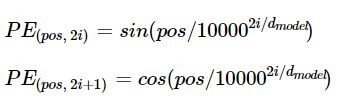

Transformer는 위치 정보를 가진 값을 만들기 위해서 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 준다.  
여기서 pos. i, d_model은 아래와 같다.   
pos: 입력 문장에서의 임베딩 벡터의 위치  
i: 임베딩 벡터 내의 각 차원의 인덱스가 짝수라면 사인 함수, 홀수라면 코사인 함수를 사용한다.  
d_model: Transformer의 모든 층의 출력 차원을 의미, 아래 그림상에서는 4이나 앞선 하이퍼파라미터의 경우처럼 512이다.


In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    # 사인함수, 코사인함수의 수식에서 1/10000^(2i/d_model) 구하기 
    return position * angles
    # 앞서 구한 값에 position 곱하여 반환

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


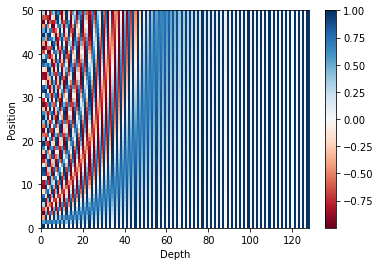

In [3]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
# 이는 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

어탠션 매커니즘을 수행한다. 각 Q벡터는 모든 K벡터에 대하여 어탠션 스코어를 구한 후 softmax를 통과하여 어탠션 분포를 구한다. 이를 V벡터와 가중합하여 어탠션 값(컨택스트 벡터)를 구한다. 이를 모든 Q벡터에 대하여 수행한다.   
이때 transformer는 어탠션 함수로 scaled dot production을 사용하는데 기존의 dot product(내적)에 square root를 씌운 d_k를 나누어 scaling을 하는 효과를 보이기 때문이다. 위 과정을 일괄적으로 처리하기 위하여 행렬을 사용한다. Q행렬과 K행렬의 전치를 곱하여 어탠션 스코어를 구하는 방식을 사용한다. 이 결과를 V행렬과 곱하여 어탠션 값(컨택스트 벡터)를 구한다.

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  # Q오 K의 내적이 어탠션 함수인 dot product이므로
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

멀티 헤드 어탠션(Multi-head Attention)은 앞서 다룬 어탠션을 병렬로 수행하여(num_heads 만큼 수행) 효과적인 시스템을 구현한 것이다. 병렬 어탠션을 모두 수행하였다면 모든 어탠션 헤드를 연결(concatenate)합니다.  

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

mask값에다가 -1e9라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬에 더해준다. 이 값이 소프트 맥스를 통과하면 0이 되어 이를 참고하지 않게 된다.

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

잔차 연결의 경우 각 서브층으로부터의 입력과 서브층 이전의 입력, 총 두개를 더한다. --> x + Sublayer(x)  
층 정규화의 경우 잔차 연결을 거친 결과를 층 정규화를 수행하는 것인데 수식으로는 다음과 같다.   
LN = LayerNormalize(x + Sublayer(x))  
이는 텐셔의 마지막 차원에 대해서 평균과 분산을 구하고 이를 토대로 정규화를 수행하는 것이다.


In [7]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [8]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더의 경우 인코더와 마찬가지로 임베딩 층과 포지셔녈 인코딩을 거친 후의 문장 행렬이 입력된다. *단어를 밀집 벡터의 형태로 표현하는 방법을 워드 임베딩이라 하고 이 밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라 하여 임베딩 벡터라 한다.  
Seq2seq의 경우 매 시점마다 순차적으로 입력을 받아 다음단어 예측에 현재 시점의 단어를 예측하고자 할 때, 입력 단어를 매 시점마다 순차적으로 받으므로 다음 단어 예측에 이전의 입력 데이터 단어들로만 참고할 수 있다. 반면, 트랜스포머는 문장 행렬로 입력을 한번에 받으므로 현재시점의 단어를 예측하고자 할 때 미래시점의 단어까지도 참고할 수 있는 현상이 발생한다. 이를 방지하기 위하여 look-ahead mask를 도입하였다.
 


In [9]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [14]:
'''
1. multi-head self-attention
2. multi-head attention
3. position-wise FFNN
''' 
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [11]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [12]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


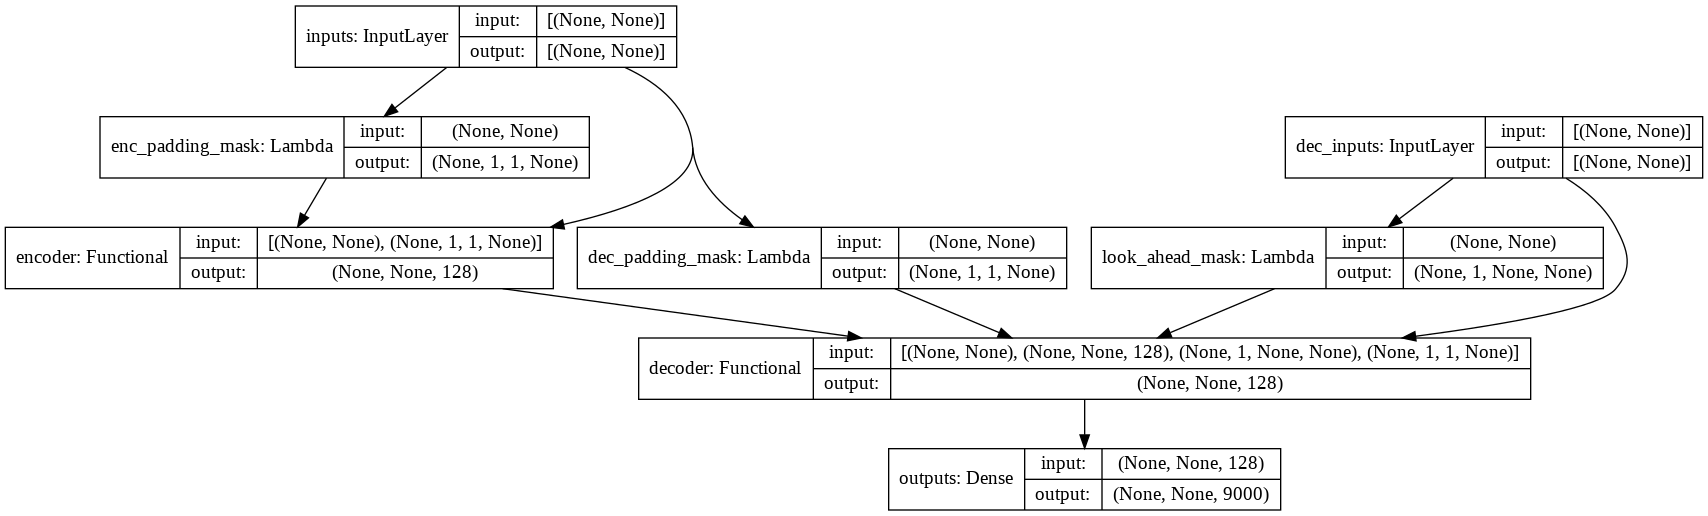

In [15]:
#가벼운 트랜스포머를 위하여
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [16]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

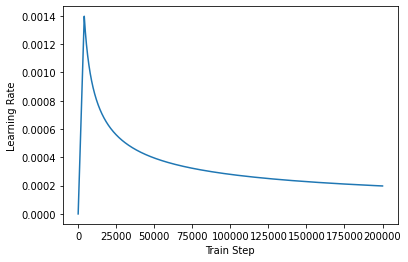

In [18]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [21]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [32]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

#stop_words = "아무거나 아무렇게나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 하면 아니거든"
# 위의 불용어는 명사가 아닌 단어 중에서 저자가 임의로 선정한 것으로 실제 의미있는 선정 기준이 아님
#stop_words=stop_words.split(' ')

In [89]:
f = open("/content/drive/MyDrive/불용어.txt", 'r')
stop_words=""
lines = f.readlines() # 파일의 모든 줄을 읽음, 각각의 줄을 요소로 갖는 리스트 반환
for line in lines: # 파일의 각 줄에 해당하는 부분
    stop_words += line
    stop_words += " "
f.close()
stop_words=stop_words.split(' ')

In [90]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [92]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [93]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [94]:
#불용어 제거 수행
result_questions = []
for i in range(len(questions)):
    #문장 토큰화
    word_tokens = word_tokenize(questions[i])
    temp_string=""
    result_q = []
    #단어가 불용어에 있지 않다면 임시 result 리스트에 할당 
    for w in word_tokens: 
        if w not in stop_words: 
            result_q.append(w)
            #print(result_q)
    #임시 result 리스트의 값들 더 하여(띄어쓰기 포함) 문장으로 생성
    for j in range(len(result_q)):
        temp_string +=result_q[j]
        if j < len(result_q)-1:
            temp_string+=" "
    #생성한 문장을 최종 result 리스트에 append
    result_questions.append(temp_string)
    # 위의 4줄은 아래의 한 줄로 대체 가능
    # result=[word for word in word_tokens if not word in stop_words]

In [95]:
print(result_questions)

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지ㅠㅠ', 'SNS 시간낭비인 거 아는데 매일 중', 'SNS 시간낭비인데 자꾸 보게됨', 'SNS보면 나만 빼고 다 행복해보여', '가끔 궁금해', '가끔 뭐하는지 궁금해', '가끔은 혼자인게 좋다', '가난한 자의 설움', '가만 있어도 땀난다', '가상화폐 쫄딱 망함', '가스불 켜고 나갔어', '가스불 켜놓고 나온거 같아', '가스비 너무 많이 나왔다 .', '가스비 비싼데 감기 걸리겠어', '가스비 장난 아님', '가장 확실한 건 뭘까 ?', '가족 여행 가기로 했어', '가족 여행 고고', '가족 여행 어디로 가지 ?', '가족 있어 ?', '가족관계 알려 줘', '가족끼리 여행간다 .', '가족들 보고 싶어', '가족들이랑 서먹해', '가족들이랑 서먹해졌어', '가족들이랑 어디 가지 ?', '가족들이랑 여행 갈거야', '가족여행 가야지', '가족이 누구야 ?', '가족이랑 여행 가려고', '가족한테 스트레스 풀었어', '가출할까 ?', '가출해도 갈 데가 없어', '간만에 떨리니까 좋더라', '간만에 쇼핑 중', '간만에 휴식 중', '간식 뭐 먹을까', '간식 추천', '간장치킨 시켜야지', '간접흡연 싫어', '갈까 말까 고민 돼', '갈까 말까 ?', '감 말랭이 먹고 싶다 .', '감 말랭이 먹어야지', '감기 같애', '감기 걸린 것 같아', '감기 기운이 있어', '감기 들 거 같애', '감기가 오려나', '감기약이 없어', '감기인거 같애', '감미로운 목소리 좋아', '감정이 쓰레기통처럼 엉망진창이야', '감정컨트롤을 못하겠어', '감정컨트롤이 안돼', '감히 나를 무시하는 애가 있어', '갑자기 나쁜 생각이 막 들더라', '갑자기 눈물 나', '갑자기 물어봐서 당황했어', '갑자기 불편한 사이가 된 거 같아', '강렬한 첫인상 남겨야 하는데

In [96]:
#불용어 제거 수행
result_answers = []
for i in range(len(answers)):
    #문장 토큰화
    word_tokens = word_tokenize(answers[i])
    temp_string2=""
    result_a = [] 
    #단어가 불용어에 있지 않다면 임시 result 리스트에 할당 
    for w in word_tokens: 
        if w not in stop_words: 
            result_a.append(w)
            #print(result_a)
    #임시 result 리스트의 값들 더 하여(띄어쓰기 포함) 문장으로 생성
    for j in range(len(result_a)):
        temp_string2 +=result_a[j]
        if j < len(result_a)-1:
            temp_string2+=" "
    #생성한 문장을 최종 result 리스트에 append
    result_answers.append(temp_string2)
    # 위의 4줄은 아래의 한 줄로 대체 가능
    # result=[word for word in word_tokens if not word in stop_words]

In [97]:
print(result_answers)

['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '새로 사는 게 마음 편해요 .', '새로 사는 게 마음 편해요 .', '잘 모르고 있을 수도 있어요 .', '시간을 정하고 해보세요 .', '시간을 정하고 해보세요 .', '자랑하는 자리니까요 .', '그 사람도 그럴 거예요 .', '그 사람도 그럴 거예요 .', '혼자를 즐기세요 .', '돈은 들어올 거예요 .', '땀을 식혀주세요 .', '어서 잊고 새출발 하세요 .', '빨리 집에 돌아가서 끄고 나오세요 .', '빨리 집에 돌아가서 끄고 나오세요 .', '다음 달에는 더 절약해봐요 .', '따뜻하게 사세요 !', '다음 달에는 더 절약해봐요 .', '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '더 가까워질 기회가 되겠네요 .', '저도요 .', '다들 바빠서 이야기할 시간이 부족했나봐요 .', '다들 바빠서 이야기할 시간이 부족했나봐요 .', '온 가족이 모두 마음에 드는 곳으로 가보세요 .', '좋은 생각이에요 .', '더 가까워질 기회가 되겠네요 .', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요', '좋은 생각이에요 .', '정말 후회할 습관이에요 .', '무모한 결정을 내리지 마세요 .', '선생님이나 기관에 연락해보세요 .', '떨리는 감정은 그 자체로 소중해요 .', '득템했길 바라요 .', '휴식도 필요하죠 .', '단짠으로 두 개 사는게 진리죠 .', '단짠으로 두 개 사는게 진

In [98]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    result_questions + result_answers, target_vocab_size=2**13)

In [99]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [100]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8157]
종료 토큰 번호 : [8158]
단어 집합의 크기 : 8159


In [101]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [5746, 619, 3492, 131, 665, 3727, 828]


In [102]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5746, 619, 3492, 131, 665, 3727, 828]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [103]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5746 ----> 가스
619 ----> 비 
3492 ----> 비싼
131 ----> 데 
665 ----> 감기 
3727 ----> 걸리
828 ----> 겠어


In [104]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [105]:
questions, answers = tokenize_and_filter(result_questions, result_answers)

In [106]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [107]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [108]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8157 3824   69 7876    1 8158    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8157 3824   69 7876    1 8158    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3824   69 7876    1 8158    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [121]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 512
NUM_LAYERS = 6
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8159, 512)
(1, 8159, 512)


In [123]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [125]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS)

Epoch 1/30
185/185 [==============================] - 50s 271ms/step - loss: 1.0117 - accuracy: 0.0499
Epoch 2/30
185/185 [==============================] - 50s 272ms/step - loss: 0.9452 - accuracy: 0.0512
Epoch 3/30
185/185 [==============================] - 50s 271ms/step - loss: 0.9074 - accuracy: 0.0534
Epoch 4/30
185/185 [==============================] - 50s 271ms/step - loss: 0.8747 - accuracy: 0.0550
Epoch 5/30
185/185 [==============================] - 50s 271ms/step - loss: 0.8403 - accuracy: 0.0566
Epoch 6/30
185/185 [==============================] - 50s 270ms/step - loss: 0.8037 - accuracy: 0.0586
Epoch 7/30
185/185 [==============================] - 50s 270ms/step - loss: 0.7594 - accuracy: 0.0614
Epoch 8/30
185/185 [==============================] - 50s 271ms/step - loss: 0.7084 - accuracy: 0.0651
Epoch 9/30
185/185 [==============================] - 50s 270ms/step - loss: 0.6535 - accuracy: 0.0700
Epoch 10/30
185/185 [==============================] - 50s 271ms/step - l

In [112]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [113]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [114]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [126]:
output = predict("배고파")

Input: 배고파
Output: 얼른 뭐라도 드세요 .
